### 1)Extraction des données 

In [1]:
import os
from os import listdir, path
import tarfile
import random
import numpy as np
import keras
from keras.preprocessing.image import img_to_array, load_img
import tensorflow as tf
import matplotlib.pyplot as plt
from skimage.io import imread
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [2]:
#attention au path bien avoir une hierarchie : data -> Dossier suivant dans data : data_test.tar.gz ,data_train.tar.gz, data_train.csv 
if not path.exists('data/data_test/'):
    print('Extracting test image files...')
    tar = tarfile.open("./data/data_test.tar.gz", "r:gz")
    tar.extractall('data/')
if not path.exists('data/data_train/'):
    print('Extracting train image files...')
    tar = tarfile.open("./data/data_train.tar.gz", "r:gz")
    tar.extractall('data/')

### Display utility functions

In [2]:
def show(image):
    plt.imshow(np.squeeze(image.astype("uint8")), cmap="gray")
    plt.title("image shape: "+ str(image.shape), fontsize=14)
    plt.axis('off');
    
def show_multiple(images, figsize):
    fig, ax = plt.subplots(ncols=len(images), figsize=figsize)
    for col, image in zip(ax, images):
        col.imshow(np.squeeze(image.astype("uint8")), cmap="gray")
        col.set_title("image shape: "+ str(image.shape), fontsize=14)
    plt.tight_layout()
    plt.axis('off');

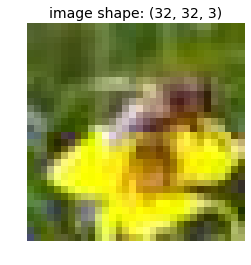

In [3]:
sample_image = imread("./data/data_train/10.jpg")
show(sample_image)

### Importer les Images (Train and Test) et les trier afin qu'elles soient en adéquation avec le fichier CSV

In [3]:
import pandas as pd

def load_data(data_path):
    csv_path = os.path.join(data_path, "labels_train.csv")
    return pd.read_csv(csv_path) # note the returned variable

In [4]:
GLOBAL_DATA_PATH = "./data"
data = load_data(GLOBAL_DATA_PATH) #Pemet de charger les données du CSV
#y_train = load_data(GLOBAL_DATA_PATH)

In [5]:
import shutil, os

def split_img_in_subfolders(data) :
    for i in range(data.shape[0]) : 
        animal_folder_path = os.path.join('./','data', 'data_train', data['Category'][i])
        
        # Create folder if doesn't exist 
        if not path.exists(animal_folder_path):
            os.mkdir(animal_folder_path)
            
        # Copy the img in the associated folder    
        shutil.copy(os.path.join('./', 'data', 'data_train', str(data['Id'][i])) +'.jpg', os.path.join(animal_folder_path , str(data['Id'][i]) +'.jpg'))

In [8]:
#split_img_in_subfolders(data)

In [5]:
def get_classes() :
    classes = []
    for animal in data['Category'] :
        if (animal not in classes) : 
            classes.append(animal)
        
    return classes

In [6]:
def get_splitted_data_with_size(image_size, sample_size, test_ratio, classes, seed):
    X, Y = [], []
    for label, animal in enumerate(classes):
        files = listdir(path.join('./data/data_train', animal))
        random.shuffle(files)
        files = files[:(sample_size // len(classes))]
        for file in files:
            img = load_img(path.join('./data/data_train', animal, file), 
                           target_size=image_size)
            X.append(img_to_array(img))
            Y.append(label)
            
    return train_test_split(np.asarray(X), np.asarray(Y), test_size=test_ratio, random_state=seed)

In [8]:
data.shape

(7200, 2)

In [7]:
image_size = (32, 32, 3)
keras_size = (224, 224, 3)
sample_size = 500
classes = get_classes()

X_tr, X_val, y_tr, y_val = get_splitted_data_with_size(
    image_size=image_size, sample_size=sample_size, test_ratio=0.25, classes=classes, seed=42
)

In [10]:
X_tr.shape, X_val.shape, y_tr.shape, y_val.shape

((742, 32, 32, 3), (248, 32, 32, 3), (742,), (248,))

In [11]:
len(classes)

15

chimpanzee


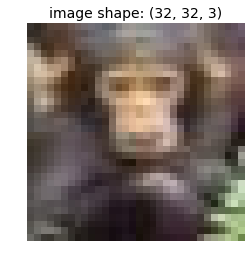

In [12]:
show(X_tr[1])
print(classes[y_tr[1]])

### MODEL : VIA RESNET 50 

In [8]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Activation, BatchNormalization
from keras import optimizers
from keras import utils as np_utils


model = Sequential()
model.add(Flatten(input_shape=X_tr.shape[1:]))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(classes), activation='softmax'))

model.compile(optimizer=optimizers.SGD(lr=1e-4, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

y_tr = np_utils.to_categorical(y_tr, len(classes))
y_val = np_utils.to_categorical(y_val, len(classes))

In [9]:
batch_size = 32
num_epochs = 20

from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

datagen.fit(X_tr)
tr_generator = datagen.flow(X_tr, y_tr, batch_size=batch_size)
val_generator = datagen.flow(X_val, y_val, batch_size=batch_size)

In [10]:
X_tr.shape[0]

371

In [11]:

# fine-tune the model
model_history = model.fit_generator(
    tr_generator,
    steps_per_epoch=1000,
    epochs=num_epochs,
    validation_data=val_generator,
    validation_steps=800)

Epoch 1/20
1000/1000 [==============================] - 37s 37ms/step - loss: 2.6329 - acc: 0.2076 - val_loss: 2.5055 - val_acc: 0.1855
Epoch 2/20
1000/1000 [==============================] - 36s 36ms/step - loss: 2.2203 - acc: 0.2818 - val_loss: 2.4695 - val_acc: 0.2111
Epoch 3/20
1000/1000 [==============================] - 39s 39ms/step - loss: 2.0919 - acc: 0.3125 - val_loss: 2.4349 - val_acc: 0.2272
Epoch 4/20
1000/1000 [==============================] - 41s 41ms/step - loss: 2.0147 - acc: 0.3337 - val_loss: 2.4292 - val_acc: 0.2287
Epoch 5/20
1000/1000 [==============================] - 34s 34ms/step - loss: 1.9561 - acc: 0.3486 - val_loss: 2.4238 - val_acc: 0.2363
Epoch 6/20
1000/1000 [==============================] - 36s 36ms/step - loss: 1.8998 - acc: 0.3661 - val_loss: 2.4306 - val_acc: 0.2350
Epoch 7/20
1000/1000 [==============================] - 42s 42ms/step - loss: 1.8716 - acc: 0.3757 - val_loss: 2.4401 - val_acc: 0.2413
Epoch 8/20
1000/1000 [==========================

In [48]:
y_val.shape

(248, 15, 15, 15)

In [ ]:
model.summary()

In [13]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    for ax, metric, name in zip(axs, ['acc', 'loss'], ['Accuracy', 'Loss']):
        ax.plot(
            range(1, len(model_history.history[metric]) + 1), 
            model_history.history[metric]
        )
        ax.plot(
            range(1, len(model_history.history['val_' + metric]) + 1), 
            model_history.history['val_' + metric]
        )
        ax.set_title('Model ' + name)
        ax.set_ylabel(name)
        ax.set_xlabel('Epoch')
        ax.legend(['train', 'val'], loc='best')
    plt.show()

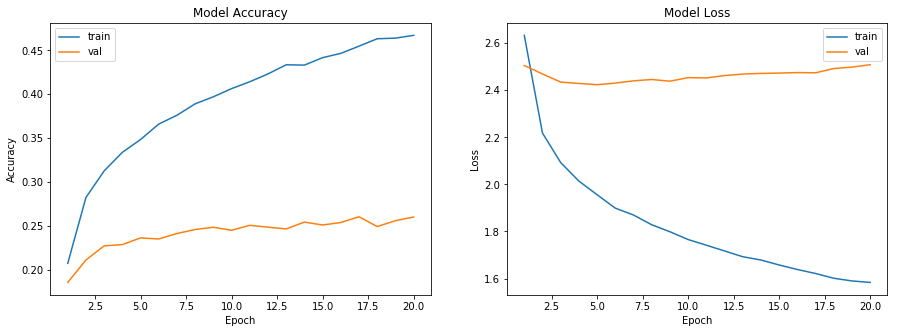

In [14]:
plot_model_history(model_history)

## Prediction

In [15]:
def conv(v):
    v2 = [s.strip('.jpg') for s in v] # remove the .jpg from the string borders 
    v2 = list(map(int, v2))
    return v2

In [16]:
def int_to_imagepath (v):
    v1 = list(map(str, v))
    #print (v1)
    v1 = [s.replace(s,s+".jpg") for s in v1] 
    return v1

In [17]:
X_test = []
files = []
files_test = listdir(path.join(GLOBAL_DATA_PATH, "data_test"))
files2_test = conv(files_test) # convertion string to int
files3_test = sorted(files2_test) # classement ordre croissant
files4_test = int_to_imagepath (files3_test)

for file in files4_test:
    img = load_img(path.join(GLOBAL_DATA_PATH, "data_train", file))
    X_test.append(img_to_array(img))

print("X_test lenght : ",len(X_test))

X_test lenght :  1800


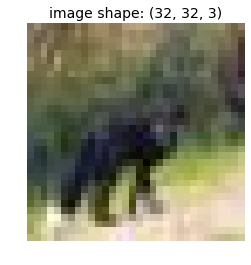

In [36]:
show(np.asarray(X_test[7]))

In [21]:


y_test = model.predict_classes(np.asarray(X_test))

In [37]:
classes[y_test[7]]

'wolf'

In [75]:
import csv

id = 23
animal = 'chimpanzee'

with open('submition.csv', 'w', newline='') as csvfile:
    
    spamwriter = csv.writer(csvfile, delimiter='',quotechar='|', quoting=csv.QUOTE_MINIMAL)
    spamwriter.writerow({'Id,Category'})
    
    for i in range(4) : 
    
        spamwriter.writerow({i,',',classes[y_test[i]]})


In [50]:
import numpy as np
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.models import Model
from keras.preprocessing import image
from skimage.transform import resize
from skimage.io import imread

In [67]:
 #Basic Implementation of resnet model
model_ResNet50 = ResNet50(include_top=True, weights='imagenet')
model_ResNet50.layers.pop()
#model_ResNet50.summary()

In [68]:
model_ResNet50.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [102]:
#print(X_tr)
#print(y_tr)

In [69]:
if model_ResNet50:
    X_extracted_tr = model_ResNet50.predict(preprocess_input(X_tr), verbose=1)
    X_extracted_val = model_ResNet50.predict(preprocess_input(X_val), verbose=1)
    print('Done extracting resnet50 features..')

248/248 [==============================] - 66s 267ms/step
Done extracting resnet50 features..


In [36]:
print("X_extracted_tr : ", X_extracted_tr.shape)

X_extracted_tr :  (67, 1000)


In [28]:
from keras import optimizers

sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

In [223]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Activation, BatchNormalization
from keras.optimizers import Adam

batch_size = 128
num_epochs = 20

transfer_model = Sequential()

kernel_height = 5
kernel_width = 5
output_filter = 32
output_filter2 = 64
input_image = (image_size[0], image_size[1], image_size[2])
activation1 = 'relu'
activation2 = 'sigmoid'

"""
# TODO: 1st Convolution Layer
transfer_model.add(Conv2D(output_filter2, (kernel_height, kernel_width), padding='SAME', input_shape=(image_size[0], image_size[1], image_size[2]))) 
transfer_model.add(Activation('relu')) 
transfer_model.add(BatchNormalization())
transfer_model.add(MaxPooling2D(pool_size=(2, 2)))

#2nd Convolution Layer
transfer_model.add(Conv2D(output_filter2, (kernel_height, kernel_width)))
transfer_model.add(Activation(activation1)) 
transfer_model.add(BatchNormalization())
transfer_model.add(MaxPooling2D(pool_size=(2, 2)))

transfer_model.add(Flatten())
transfer_model.add(Dropout(0.5))
#transfer_model.add(Dense(128, activation = 'relu'))
transfer_model.add(Dense(1, activation = 'sigmoid'))"""



transfer_model.add(Conv2D(output_filter, (kernel_height, kernel_width), padding='SAME', input_shape=input_image)) 
transfer_model.add(Activation('relu')) 
transfer_model.add(BatchNormalization())
transfer_model.add(MaxPooling2D(pool_size=(2, 2)))

transfer_model.add(Conv2D(output_filter2, (3, 3), padding='SAME', input_shape=input_image)) 
transfer_model.add(Activation('relu')) 
transfer_model.add(BatchNormalization())
transfer_model.add(MaxPooling2D(pool_size=(2, 2)))

transfer_model.add(Flatten())
transfer_model.add(Dropout(0.4))
transfer_model.add(Dense(126, activation='relu'))
transfer_model.add(Dropout(0.25))
#transfer_model.add(Dense(10, activation='softmax'))
transfer_model.add(Dense(1))

    
transfer_model.compile(optimizer='adam',loss='mean_squared_error',metrics=['accuracy'])